In [98]:
# Importing Libraries and Load Data
import pandas as pd
import numpy as np
import requests
from io import StringIO
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score, KFold

url = 'https://data.ny.gov/api/views/cwsm-2ns3/rows.json'
json_data = fetch_data_from_api(url)

if json_data:
    df = create_dataframe_from_json(json_data)
    if df is not None:
        print(df.head())
    else:
        print("Failed to create DataFrame.")
else:
    print("Failed to fetch JSON data.")

200
                  sid                                    id  position  \
0  row-594w~92jq-97pp  00000000-0000-0000-CA2F-7F934A37A55D         0   
1  row-wquh~rjkx.ngf5  00000000-0000-0000-B1BD-4F424A56B62D         0   
2  row-acgk-pwmg.8qkb  00000000-0000-0000-E03E-91899E1E24A6         0   
3  row-adak~grmg~ndpi  00000000-0000-0000-087D-188AA21D496C         0   
4  row-hyt3_jsbw.vdhi  00000000-0000-0000-EDBA-67F3F1FA24AF         0   

   created_at created_meta  updated_at updated_meta meta Area Type  \
0  1718897298         None  1718897298         None  { }     State   
1  1718897298         None  1718897298         None  { }    County   
2  1718897298         None  1718897298         None  { }    County   
3  1718897298         None  1718897298         None  { }    County   
4  1718897298         None  1718897298         None  { }    County   

              Area  Year Quarter              Ownership NAICS  \
0   New York State  2023       1     Federal Government    00   
1    A

In [100]:
# Convert 'year' column to numeric 
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Subset the data for the year 2015 and State - New York
df = df[(df['Year'] >= 2015) & (df['Area'] == 'New York State')]

In [104]:
# Data Exploration and Cleaning
print("Data Exploration:\n", df.info())
print("Any Null values Present in Data:\n", df.isnull().values.any())
print("Explore the dataset:\n", df.head(5))

# Removing columns that are not Necessary for the Analysis
df = df.iloc[:, 8:]

# Changing the column names to case-sensitive
df.columns = df.columns.map(lambda x : x.replace("-", "_").replace(" ", "_")) 
df.columns = df.columns.str.lower()
df = df.rename(columns={df.columns[-1]: 'total_wage'})

# Removing columns/Data Reduction
df = df.drop(['area_type', 'area',
              'month_1_employment', 'month_2_employment',
             'month_3_employment', 'naics'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14885 entries, 0 to 819339
Data columns (total 12 columns):
 #   Column                                                                                                                             Non-Null Count  Dtype 
---  ------                                                                                                                             --------------  ----- 
 0   Area Type                                                                                                                          14885 non-null  object
 1   Area                                                                                                                               14885 non-null  object
 2   Year                                                                                                                               14885 non-null  int64 
 3   Quarter                                                                                   

In [40]:
# Data Standardization
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

scalar = StandardScaler()      # Calling the Module
# Standardizing the data in the two columns
df['total_wage_std'] = scalar.fit_transform(df[['total_wage']])

# Outlier Detection And Outlier Removal
df['outlier'] = LocalOutlierFactor().fit_predict(df[['total_wage']])

filtered_df = df[df['outlier'] != -1]                   # Subseting the Outliers
print("Outliers Detected: ", len(df) - len(filtered_df)) # Printing the Number Of Outliers Detected

Outliers Detected:  41


       establishments  total_wage_std
count    14836.000000    14836.000000
mean      3508.861283       -0.037591
std       9469.010436        0.366467
min          3.000000       -0.172880
25%         88.000000       -0.167402
50%        501.000000       -0.147610
75%       2509.250000       -0.076342
max      89754.000000        4.715934


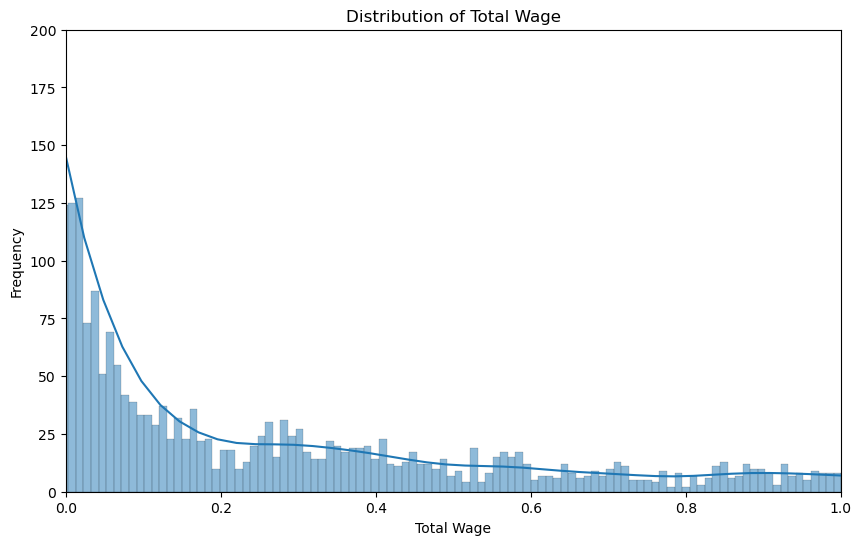

In [133]:
# EDA with Visualizations
df = filtered_df.copy()
df['establishments'] = pd.to_numeric(df['establishments'], errors='coerce') # Converting establishments to numeric For Analysis
df['year'] = df['year'].astype(str)                                         # Converting year to Object/Str
df['outlier'] = df['outlier'].astype(str)                                   # Convertinf outliers to str

# EDA For Numeric variables
print(df.describe())                                 # Prints the table of Descriptive Statistics for Numeric columns

# Visualization for Distribution of total wage
plt.figure(figsize=(10, 6))                            # Setting Plot Size
sns.histplot(df['total_wage_std'], bins=500, kde=True) # Passing the data
# Adding plot titles and labels
plt.title('Distribution of Total Wage')
plt.xlabel('Total Wage')
plt.ylabel('Frequency')
plt.xlim(left=0, right=1)                              # Setting the X-axis margins between 0 and 1
plt.ylim(top=200)                                      # Setting the y-axis limit to make graph visualy appealing
plt.show()                                             # Displays the plot

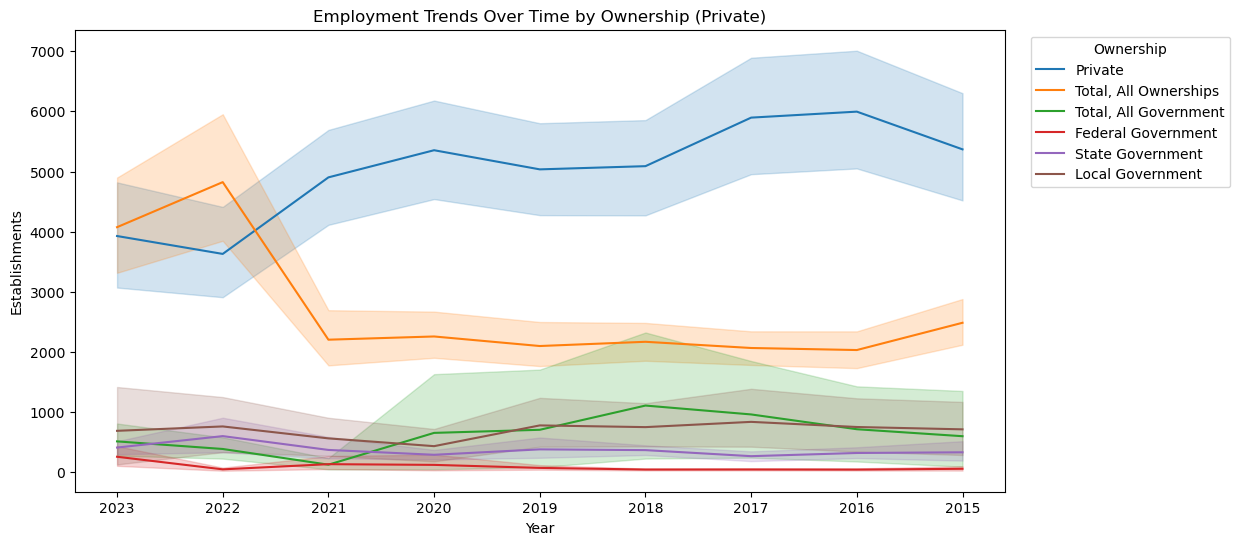

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

""" Line Chart For Employment Trend Across 
    Establishments over time
"""
plt.figure(figsize=(12, 6))                                              # Setting the plot size
sns.lineplot(x='year', y='establishments', hue='ownership', data=df)     # Passing the data
# Adding plot titles and labels
plt.title('Employment Trends Over Time by Ownership')          
plt.xlabel('Year')
plt.ylabel('Establishments')
plt.legend(title='Ownership', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()                                                                # Displays the plot

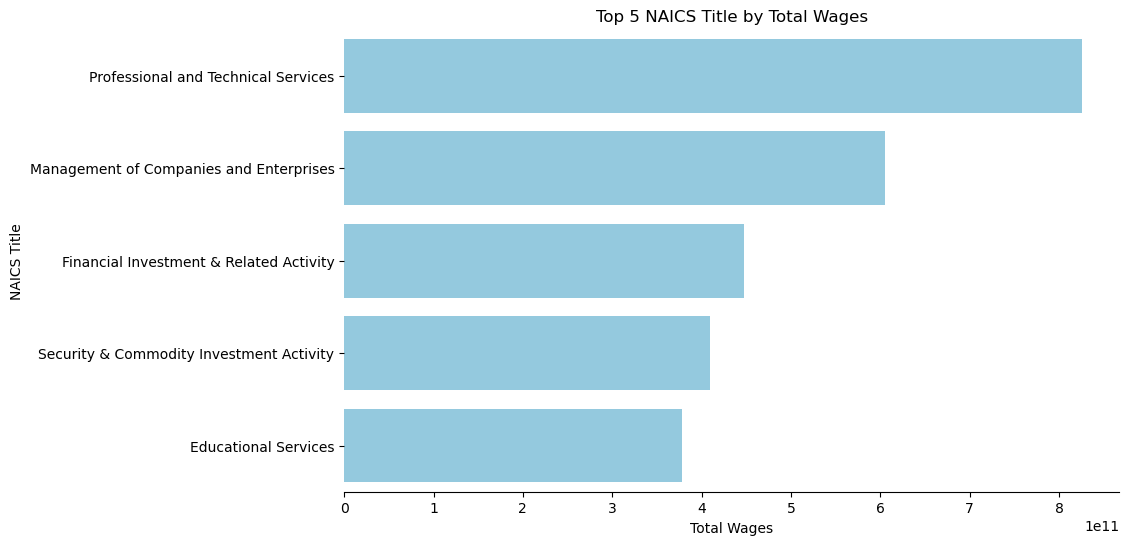

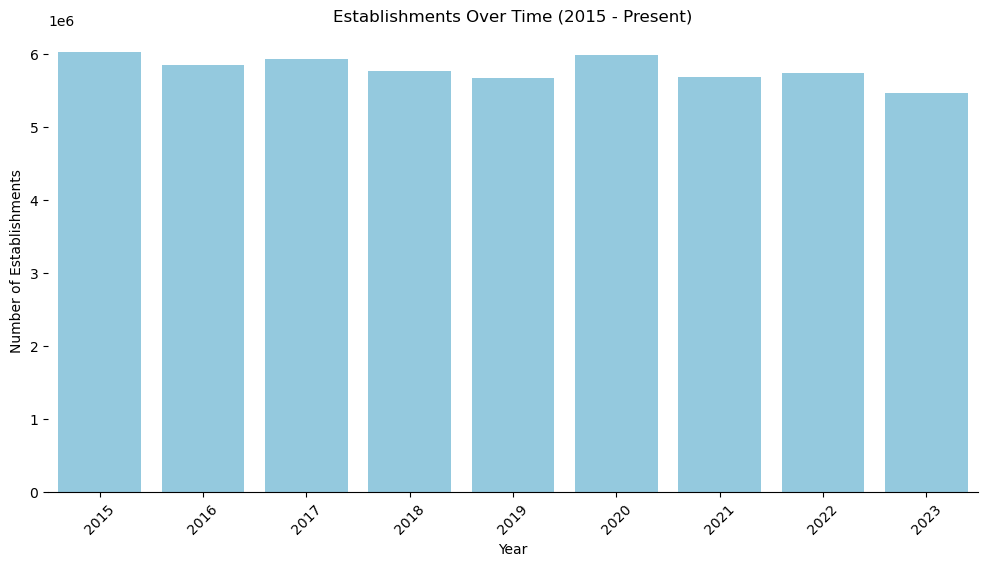

In [110]:
"""Top 5 sectors by total wages

    Horizontal bar chart for top 5 Industry titles 
    and their sum of total wages over time.
"""
# Convert 'total_wage' column to numeric
df['total_wage'] = pd.to_numeric(df['total_wage'], errors='coerce')

plt.figure(figsize=(10, 6))
# Grouping/Filtering the data by title and summing their total wages 
# And filtereing only the top 5
top_sectors = df.groupby('naics_title')['total_wage'].sum().nlargest(5)

sector = list()
for i in top_sectors.index:
    sector.append(i)

sns.barplot(x=top_sectors.values, y=sector, color='skyblue')
# Adding plot titles and labels
plt.title('Top 5 NAICS Title by Total Wages')
plt.xlabel('Total Wages')
plt.ylabel('NAICS Title')
# Removing spines from unnecessary axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()


""" Establishments Over Time

    Vertical Bar charts of total establishments
    for that year
"""
# Establishments Over Time
plt.figure(figsize=(12, 6))
establishments_over_time = df.groupby('year')['establishments'].sum()
sns.barplot(x=establishments_over_time.index, y=establishments_over_time.values, color='skyblue')
# Adding plot titles and labels
plt.title('Establishments Over Time (2015 - 2023)')
plt.xlabel('Year')
plt.ylabel('Number of Establishments')
plt.xticks(rotation=45)

# Removing spines from unnecessary axes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Administrator\a

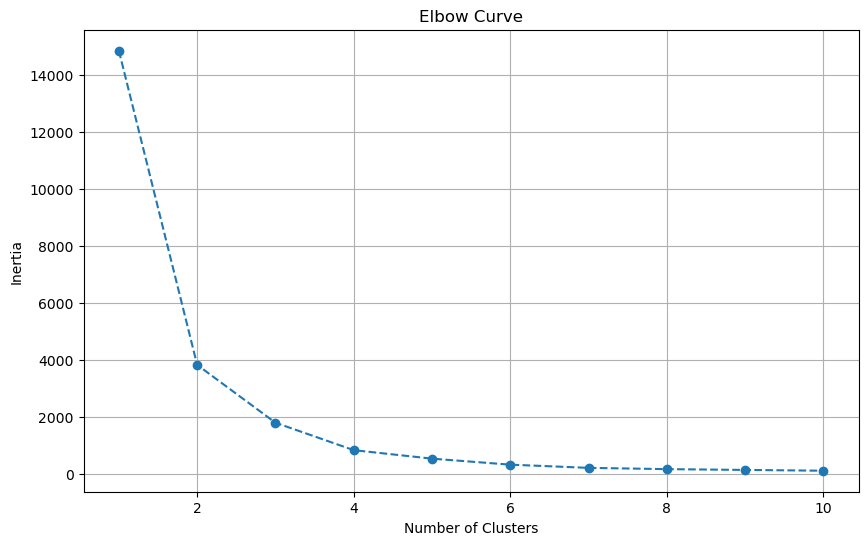

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


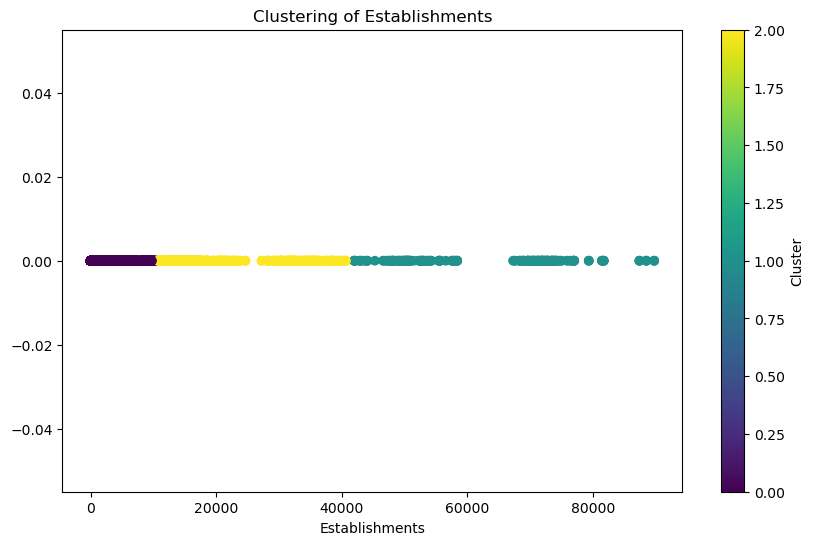

Silhouette_score For Clustering:  0.85602407874121


In [126]:
"""Clustering to Identify Patterns in Establishments

    Performed KMeans clustering after the feature is standardized
    Determined the optimal number of clusters using an Elbow Curve method (k=3)
    Evaluated clustering quality with silhouette score
    Visualized clustering results with a scatter plot coloured by cluster labels,
    showcasing how establishments are grouped based on similarity.
"""
# Importing Libraries
from sklearn.metrics import silhouette_score

# Data Standardization
X = df[['establishments']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Developed Elbow Curve to find the optimal number of clusters
inertia = []
# For loop iterates through the range and stores the results of each cluster in inertia array
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))                            
plt.plot(range(1, 11), inertia, marker='o', linestyle='--') # Plots the clusters for the range of 1 to 10

# Adding plot titles and labels
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.grid(True)
plt.show()                

# Performing K-means clustering with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
df['cluster'] = kmeans.labels_            # Storing the results of cluster in the dataframe 

# Visualizing clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['establishments'], np.zeros_like(X['establishments']), c=kmeans.labels_, cmap='viridis')
# Adding plot titles and labels
plt.xlabel('Establishments')
plt.title('Clustering of Establishments')
plt.colorbar(label='Cluster')
plt.show()

# Calculating silhouette score
silhouette_score = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette_score For Clustering: ", silhouette_score) # Printing the Score

Gradient Boosting Regressor - Mean Squared Error: 5.718610540958985e+18
Gradient Boosting Regressor - R-squared: -0.001065725940447848


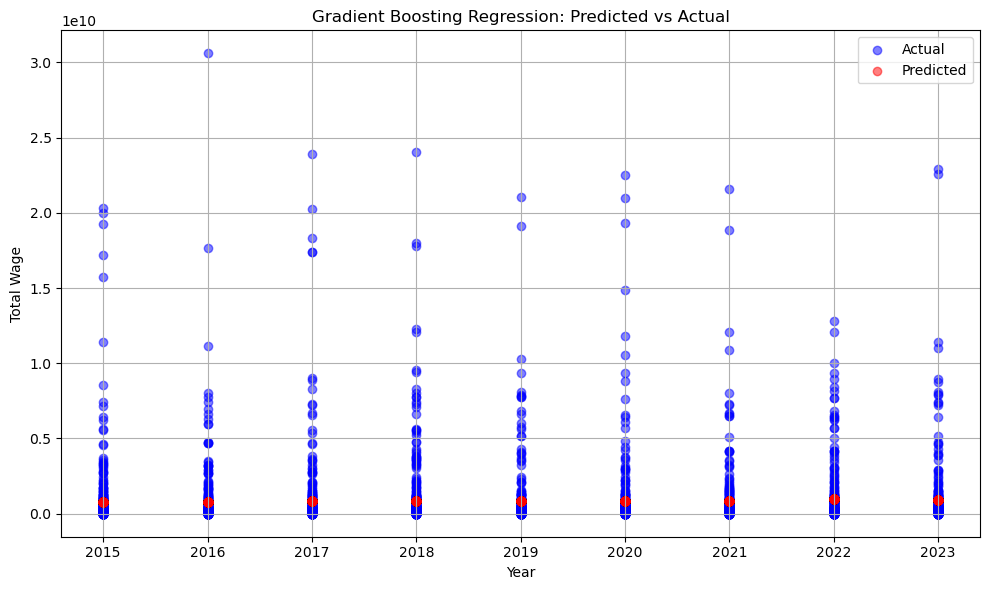

In [124]:
""" Gradient Boosting Regression on 'total_wage' using 'year' as predictors.

    Converting Year to numeric and splitting the data into train and test data.
    Initialize GradientBoostingRegressor with default settings and a random state.
    Predict 'total_wage' values on test data.
    Evaluate using Mean Squared Error (MSE) and R-squared (R2)
    Visualized model performance across different years.
"""
# Convert 'year' to numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Defining features and target variables
X = df[['year']] # feature variable
y = df['total_wage'] # Target variable

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Gradient Boosting Regressor
model_gb = GradientBoostingRegressor(random_state=42)

model_gb.fit(X_train, y_train)     # Train the model
y_pred_gb = model_gb.predict(X_test) # Predict on test data

# Evaluate model performance
mse_gb = mean_squared_error(y_test, y_pred_gb) 
r2_gb = r2_score(y_test, y_pred_gb)

# Print evaluation metrics
print(f"Gradient Boosting Regressor - Mean Squared Error: {mse_gb}")
print(f"Gradient Boosting Regressor - R-squared: {r2_gb}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')
plt.scatter(X_test, y_pred_gb, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Year')
plt.ylabel('Total Wage')
plt.title('Gradient Boosting Regression: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest Regressor - Mean Squared Error: 0.15892422962390876
Random Forest Regressor - R-squared: 0.9039780455371682


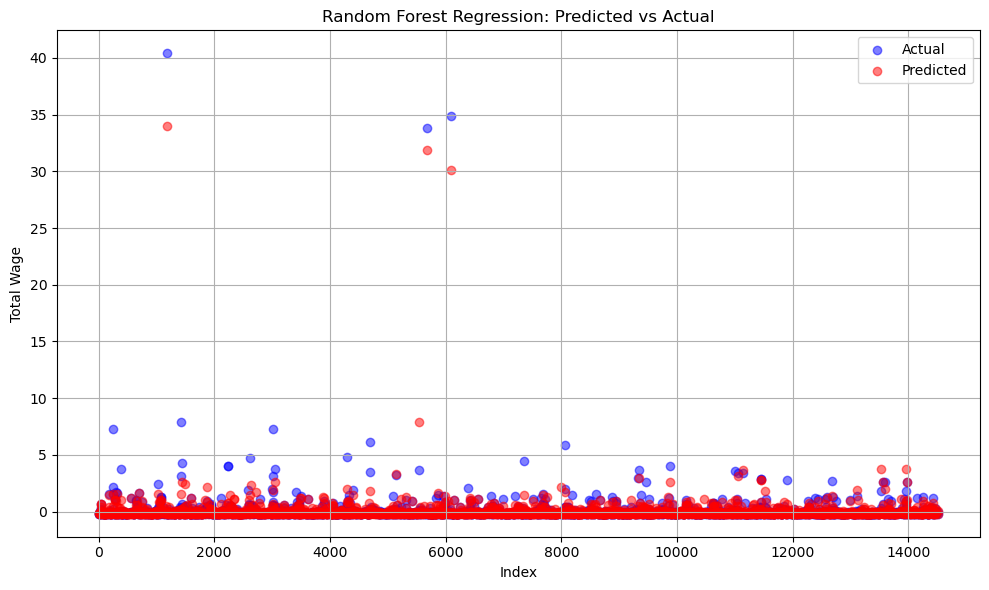

In [37]:
""" Random Forest Regression on 'total_wage' using 'year' and 'establishments' as predictors.

    Split data into training and testing sets.
    Initialize RandomForestRegressor with 100 estimators and a random state for reproducibility.
    Fit the model on training data to learn the relationship between predictors and 'total_wage'.
    Predict 'total_wage' values on test data.
    Calculate Mean Squared Error (MSE) and R-squared (R2) to assess model performance.
    Visualize model accuracy across different data points.
""" 
# Random Forest Regressor
from sklearn.model_selection import cross_val_score, KFold

# Define predictors and target variables
X = df[['year', 'establishments']]
y = df['total_wage']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor with 100 estimators
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train) # Train the model on training data
y_pred_rf = model_rf.predict(X_test) # Predict 'total_wage' values on test data
 
# Evaluate model performance using Mean Squared Error (MSE) and R-squared (R2)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Regressor - Mean Squared Error: {mse_rf}")
print(f"Random Forest Regressor - R-squared: {r2_rf}")

# Plot actual vs predicted 'total_wage'
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test, color='blue', alpha=0.5, label='Actual')
plt.scatter(y_test.index, y_pred_rf, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Total Wage')
plt.title('Random Forest Regression: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Defining K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(model_rf, _X, y, cv=kfold, scoring='accuracy')

# Print and Interpret Results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))

Decision Tree Classifier - Accuracy: 0.49793388429752067
                       precision    recall  f1-score   support

   Federal Government       0.51      0.59      0.55        96
     Local Government       1.00      0.02      0.04       100
              Private       0.53      0.67      0.59      1359
     State Government       0.00      0.00      0.00        52
Total, All Government       0.00      0.00      0.00        70
Total, All Ownerships       0.44      0.39      0.42      1227

             accuracy                           0.50      2904
            macro avg       0.41      0.28      0.27      2904
         weighted avg       0.49      0.50      0.47      2904



C:\Users\divya\Anoconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\divya\Anoconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\divya\Anoconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


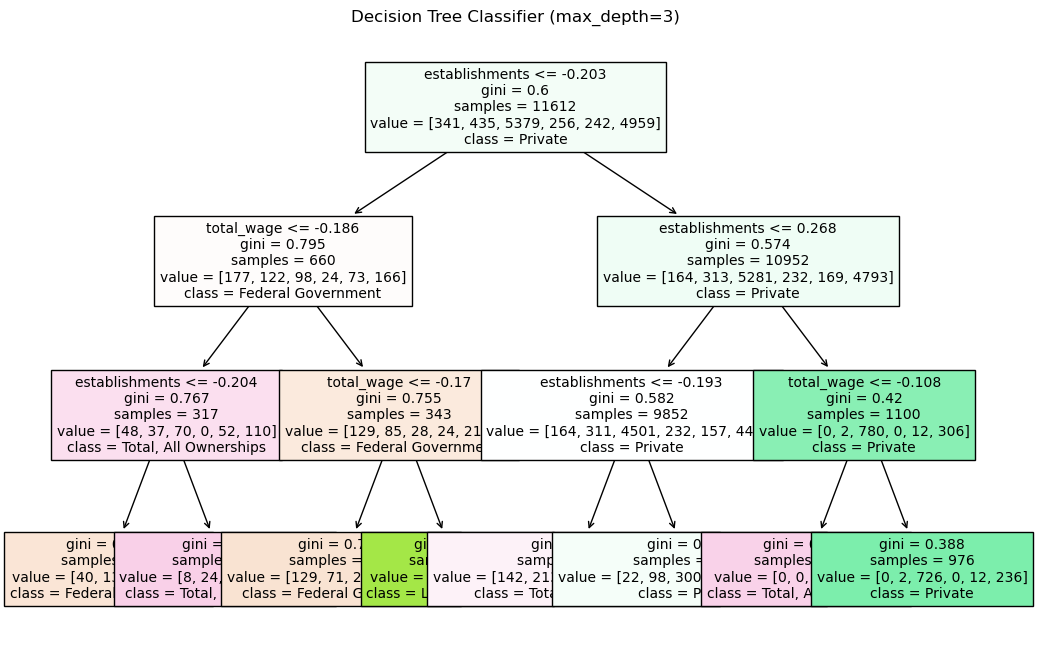

In [38]:
"""Decision Tree Classification to predict 'ownership' based on 'establishments' and 'total_wage'.

    Define predictors ('establishments' and 'total_wage') and target ('ownership').
    Split data into training and testing sets.
    Initialize DecisionTreeClassifier with max_depth=3 for interpretability and a random state for reproducibility.
    Fit the model on training data to learn the classification rules.
    Calculate Accuracy and generate a detailed classification report (including precision, recall, F1-score).
    Visualize the trained Decision Tree to understand the classification rules.
"""
# Define predictors and target variables
X = df[['establishments', 'total_wage']]
y = df['ownership']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Classifier with max_depth=3
model_dt = DecisionTreeClassifier(random_state=42, max_depth=3)
model_dt.fit(X_train, y_train)   # Train the model on training data
y_pred_dt = model_dt.predict(X_test) # Predict 'ownership' classes on test data

# Calculate model accuracy and print classification report
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Classifier - Accuracy: {accuracy_dt}")
print(classification_report(y_test, y_pred_dt))

# Visualize Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(model_dt, filled=True, feature_names=X.columns, class_names=model_dt.classes_, fontsize=10)
plt.title("Decision Tree Classifier (max_depth=3)")
plt.show()

In [130]:
import statistics
statistics.median(df['total_wage_std'])

-0.14760983362911845